In [128]:
# importing appropriate libraries and creating a dataframe for the cal fire data
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import shapely
import pickle

Reading in burn severity data from - Wildfire Burn Severity and Emissions Inventory: An Example Implementation Over California [1984-2020]
URL: https://datadryad.org/stash/dataset/doi:10.6071/M3QX18


Corresponding Investigator 
	Name: Qingqing Xu
	Institution: University of California: Merced, California, US
	Email: qxu6@ucmerced.edu

Co-investigator 1
	Name: Dr LeRoy Westerling
	Institution: University of California: Merced, California, US
    Email: leroy.westerling@icloud.com

Co-investigator 2
	Name: Dr Jonathan Baldwin
	Institution: University of California: Merced, California, US
    Email: wbaldwin@ucmerced.edu

In [129]:
fireData = gpd.read_file('./TSLF/Area_burned_in_each_burn_severity_class_and_emissions_per_fire_1984_2020.csv')
fireData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Event_ID               1697 non-null   object  
 1   Fire_Name              1697 non-null   object  
 2   Lat                    1697 non-null   object  
 3   Long                   1697 non-null   object  
 4   Fire_Year              1697 non-null   object  
 5   Fire_Month             1697 non-null   object  
 6   Total_area_burned(ha)  1697 non-null   object  
 7   Unchanged(ha)          1697 non-null   object  
 8   Low_Severity(ha)       1697 non-null   object  
 9   Moderate_Severity(ha)  1697 non-null   object  
 10  High_Severity(ha)      1697 non-null   object  
 11  Grass_Burned(ha)       1697 non-null   object  
 12  CO2(kg)                1697 non-null   object  
 13  CO(kg)                 1697 non-null   object  
 14  CH4(kg)                1697 non-

Removing emissions data from burnSeverityDF:

In [130]:
fireData = fireData.drop(columns=['CO2(kg)', 'CO(kg)', 'CH4(kg)', 'NMOC(kg)', 'SO2(kg)', 'NH3(kg)', 'NO(kg)', 'NO2(kg)', 'NOx(kg)', 'PM2.5(kg)' , 'OC(kg)', 'BC(kg)', 'geometry'])
fireData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Event_ID               1697 non-null   object
 1   Fire_Name              1697 non-null   object
 2   Lat                    1697 non-null   object
 3   Long                   1697 non-null   object
 4   Fire_Year              1697 non-null   object
 5   Fire_Month             1697 non-null   object
 6   Total_area_burned(ha)  1697 non-null   object
 7   Unchanged(ha)          1697 non-null   object
 8   Low_Severity(ha)       1697 non-null   object
 9   Moderate_Severity(ha)  1697 non-null   object
 10  High_Severity(ha)      1697 non-null   object
 11  Grass_Burned(ha)       1697 non-null   object
dtypes: object(12)
memory usage: 159.2+ KB


Reading in file for Hazardous Fuel Treatment Reduction: Polygon

Source: USDA

URL: https://data.fs.usda.gov/geodata/edw/datasets.php?dsetCategory=environment

Metadata: https://data.fs.usda.gov/geodata/edw/edw_resources/meta/S_USA.Activity_HazFuelTrt_PL.xml

Data collected by and retrieved from: Forest Service's Natural Resource Manager (NRM) Forest Activity Tracking System (FACTS)

In [131]:
infile = open('Fuel.pickle' , 'rb')
ft = pickle.load(infile)
infile.close()

Reassigned to keep only data from California:

In [132]:
ft = ft[ft["STATE_ABBR"] == "CA"]
ft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 88844 entries, 12 to 512832
Data columns (total 82 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   SUID                         88844 non-null  object             
 1   ORG                          88844 non-null  object             
 2   ACTIVITY_CODE                88844 non-null  object             
 3   ACTIVITY                     88844 non-null  object             
 4   LOCAL_QUALIFIER              88843 non-null  object             
 5   ASU_NBR_UNITS                88844 non-null  float64            
 6   ASU_UOM                      88844 non-null  object             
 7   ADMIN_REGION_CODE            88844 non-null  object             
 8   ADMIN_FOREST_CODE            88844 non-null  object             
 9   ADMIN_DISTRICT_CODE          88844 non-null  object             
 10  STATE_ABBR                   88844 n

Drop all rows that do not have data for date completed:

In [133]:
ft = ft[ft['DATE_COMPLETED'].notna()]
ft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 60445 entries, 15 to 512757
Data columns (total 82 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   SUID                         60445 non-null  object             
 1   ORG                          60445 non-null  object             
 2   ACTIVITY_CODE                60445 non-null  object             
 3   ACTIVITY                     60445 non-null  object             
 4   LOCAL_QUALIFIER              60444 non-null  object             
 5   ASU_NBR_UNITS                60445 non-null  float64            
 6   ASU_UOM                      60445 non-null  object             
 7   ADMIN_REGION_CODE            60445 non-null  object             
 8   ADMIN_FOREST_CODE            60445 non-null  object             
 9   ADMIN_DISTRICT_CODE          60445 non-null  object             
 10  STATE_ABBR                   60445 n

Sort values by year:

In [134]:
ft.sort_values(by = ['DATE_COMPLETED'], ascending = True, inplace = True)
fireData.sort_values(by = ['Fire_Name' ,  'Fire_Month' , 'Total_area_burned(ha)'], ascending = True, inplace = True) #arbitrary sort order for TSLFmerge

Drop all years before 1984:

In [135]:
ft = ft[ft["DATE_COMPLETED"].dt.year > 1983]

Drop all rows that do not have geometry data:

In [136]:
ft = ft[ft['geometry'].notna()]

Drop unnecessary columns:

In [137]:
ft = ft.drop(columns=['ASU_NBR_UNITS', 'ASU_UOM', 'SLOPE', 'ELEVATION', 'UOM', 'FEATURE_TYPE', 'SHAPE_Length', 'SHAPE_Area', 'SUID', 'ORG', 'ACTIVITY_CODE', 'ACTIVITY', 'LOCAL_QUALIFIER', 'ADMIN_REGION_CODE', 'ADMIN_FOREST_CODE', 'ADMIN_DISTRICT_CODE', 'STATE_ABBR', 'OWNERSHIP_CODE', 'PROC_REGION_CODE', 'PROC_FOREST_CODE', 'LAND_SUITABILITY_CLASS_CODE', 'PRODUCTIVITY_CLASS_CODE', 'ASPECT', 'MGT_AREA_CODE', 'MGT_PRESCRIPTION_CODE', 'NBR_UNITS_PLANNED', 'NBR_UNITS_ACCOMPLISHED', 'DATE_PLANNED', 'DATE_AWARDED', 'FISCAL_YEAR_PLANNED', 'FY_AWARDED', 'FISCAL_YEAR_COMPLETED', 'FY_PLANNED_OR_ACCOMPLISHED', 'KEYPOINT', 'FUND_CODE', 'METHOD_CODE', 'EQUIPMENT_CODE', 'COST_PER_UOM', 'NEPA_PROJECT_ID', 'NEPA_DOC_NAME', 'IMPLEMENTATION_PROJECT', 'IMPLEMENTATION_PROJECT_NBR', 'IMPLEMENTATION_PROJECT_TYPE', 'ACCOMPLISHED_UNDER_HFRA', 'ACCOMPLISHED_UNDER_HFI', 'ACTIVITY_CN', 'ACTIVITY_UNIT_CN', 'FACTS_ID', 'SUBUNIT', 'TREATMENT_TYPE', 'ACTIVITY_UNIT_NAME', 'ACTIVITY_SUB_UNIT_NAME', 'WORKFORCE_CODE', 'NEPA_PROJECT_CN', 'SUID_CN', 'ISWUI', 'CWPP', 'CAT_NM', 'EQUIPMENT', 'METHOD', 'TREATMENT_NAME', 'STAGE', 'STAGE_VALUE', 'REV_DATE', 'DATA_SOURCE', 'DATA_SOURCE_VALUE', 'ACCURACY', 'FS_UNIT_ID', 'FS_UNIT_NAME', 'CRC_VALUE', 'ETL_MODIFIED', 'UK', 'EDW_INSERT_DATE', 'UK_HAZ', 'CRC_HAZ', 'ETL_MODIFIED_DATE_HAZ', 'PURPOSE_CODE', 'ACT_CREATED_DATE', 'ACT_MODIFIED_DATE'])
ft.reset_index(drop=True, inplace=True)
ft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58566 entries, 0 to 58565
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   DATE_COMPLETED  58566 non-null  datetime64[ns, UTC]
 1   GIS_ACRES       58566 non-null  float64            
 2   geometry        58566 non-null  geometry           
dtypes: datetime64[ns, UTC](1), float64(1), geometry(1)
memory usage: 1.3 MB


Change lattitude and longitude to numeric in order to make fire point

In [138]:
fireData['Lat'] = fireData['Lat'].apply(pd.to_numeric)
fireData['Long'] = fireData['Long'].apply(pd.to_numeric)
fireData['Fire_Year'] = pd.to_datetime(fireData['Fire_Year'], format='%Y', utc=True)
ft['DATE_COMPLETED'] = pd.to_datetime(ft['DATE_COMPLETED'])
fireData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697 entries, 863 to 1626
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Event_ID               1697 non-null   object             
 1   Fire_Name              1697 non-null   object             
 2   Lat                    1697 non-null   float64            
 3   Long                   1697 non-null   float64            
 4   Fire_Year              1697 non-null   datetime64[ns, UTC]
 5   Fire_Month             1697 non-null   object             
 6   Total_area_burned(ha)  1697 non-null   object             
 7   Unchanged(ha)          1697 non-null   object             
 8   Low_Severity(ha)       1697 non-null   object             
 9   Moderate_Severity(ha)  1697 non-null   object             
 10  High_Severity(ha)      1697 non-null   object             
 11  Grass_Burned(ha)       1697 non-null   object         

Search Firedata for each fire's location/time then search Fuel reduction data to see if Fuel reduction was done in the 5 years before the fire. If yes add 1 to new column, if no keep column data as 0.

In [139]:
fireData['FuelTreatment'] = 0
length = len(fireData)

for i in range(length): 
    firePoint = Point(fireData.loc[i,'Long'] , fireData.loc[i,'Lat'])
    year_interval = ft.loc[lambda x : ((x['DATE_COMPLETED'] - fireData.loc[i, 'Fire_Year']) / np.timedelta64(1,'Y')) <= 15 ]
    year_interval = year_interval.loc[lambda x : ((x['DATE_COMPLETED'] - fireData.loc[i, 'Fire_Year']) / np.timedelta64(1,'Y')) >= 0 ]
    conditional = year_interval['geometry'].contains(firePoint).loc[lambda x : x==True]
    if(conditional.size > 0):
        for j, a in conditional.items():
            fireData.loc[i, 'FuelTreatment'] = 1

fireData.FuelTreatment.sum()

103

Fuel Treatment:
Fire Data Plot:
Overlap:


<AxesSubplot:>

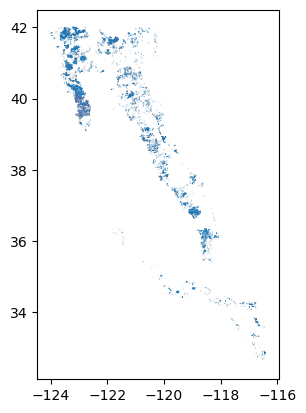

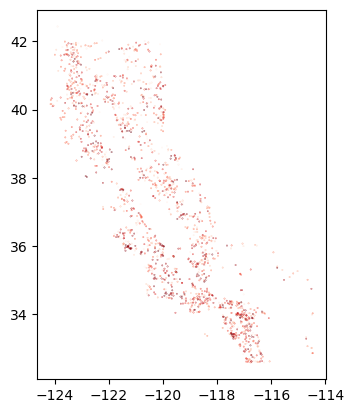

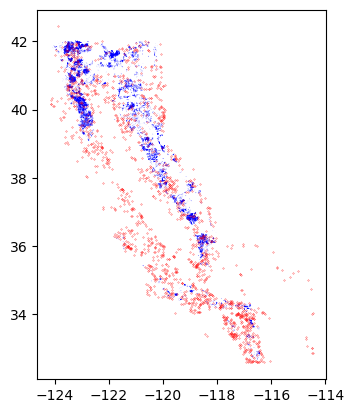

In [140]:
print('Fuel Treatment:')
ft.geometry.plot()

fireGeometry = gpd.GeoDataFrame(
    fireData, geometry = gpd.points_from_xy(fireData['Long'], fireData['Lat'] , crs='EPSG:4326')
)

print('Fire Data Plot:')
fireGeometry.plot(markersize = 0.05, cmap = 'Reds')

print('Overlap:')
ax = ft.geometry.plot(color = 'blue')

fireGeometry.plot(ax=ax, color = 'red' , markersize=0.05)

In [141]:
outfile = open('Cal1.1.pickle', 'wb')
pickle.dump(fireData, outfile)
outfile.close()

In [142]:
fireData.to_csv('Cal1.1.csv')